# Practice: Statistical analysis of the Lipinski's rule of five

## Theory

### **Molecular fingerprints**
Molecular fingerprints are essential cheminformatics tools for virtual screening and mapping chemical space. These is a way to describe a molecular structure that can convert a molecular structure into a bit string ([Seo, Shin, Myung, Hwang & No, 2020](https://doi.org/10.1186/s13321-020-0410-3)). Each bit corresponds to a predefined molecular feature or environment, where "1" represents the presence and "0" the absence of a feature. Since molecular fingerprint encodes the structure of a molecule, it is a useful method to describe the structural similarity among the molecules as a molecular descriptor. 

#### **Morgan fingerprints**
The most popular molecular fingerprint is the Morgan fingerprint that is based on the Morgan algorithm.These algorithmm generated bits correspond to the circular environments of each atom in a molecule and the number of neighboring bonds and atoms to consider is set by the radius, which are predictive of the biological activities of small organic molecules ([Capecchi, Probst & Reymond, 2020](https://doi.org/10.1186/s13321-020-00445-4)).

### **Molecular similarity measure: Tanimoto coefficient**
Two such fingerprints are most commonly compared with the Tanimoto similarity metric. These metric take  a value between 0 and 1, with 1 corresponding to identical fingerprints ([Rácz, Bajusz & Héberger, 2018](https://doi.org/10.1186/s13321-018-0302-y))


![Tanimoto-coefficient](data/Tanimoto-coefficient.jpg)

### **Clustering**
Is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups (clusters). Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties.

There are [key steps](https://www.sciencedirect.com/science/article/pii/B008045044X001474) in the clustering approach that we will folound:

**1. Data preparation and compound encoding:**

- The compounds in the input data will be encoded as molecular fingerprints.
    
**2. Tanimoto similarity (or distance) matrix:**

- The similarity between two fingerprints is calculated using the Tanimoto coefficient.
- Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs (n * n similarity matrix with =number of molecules, upper triangle matrix used only).
- Equally, the distances matrix can be calculated (1 - similarity).
    
**3. Clustering molecules**

- The clustering result depends on the threshold chosen by the user:
    - The smaller the distance value cut-off, the more similar the compounds are required to be to belong to one cluster.
    - The higher the threshold (distance cutoff), the more molecules are considered as similar, you will have less clusters.
    - The lower the threshold, the more small clusters and "singletons" appear.

## Problem Statement
We have a dataset with many compounds and we want to group them because similar compounds might bind to the same targets and show similar effects. From such a clustering, a diverse set of compounds can also be selected from a larger set of screening compounds for further experimental testing.

In [1]:
# Import the necessary libraries
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    rdFingerprintGenerator,
)

## Load dataset of GSK3B
The dataset contain the bioactive compounds against Glycogen synthase kinase-3 beta that we built in the tutorial 2.1_Dataframes. 

In [4]:
molecule_dataset = pd.read_csv("data/compounds_P49841_full.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(molecule_dataset.shape)
molecule_dataset.head()

(2605, 3)


,molecule_chembl_id,pIC50,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


### Compare query molecule to all molecules in the data set

Given one query molecule in this case Ruboxistaurin, we screen the data set for similar molecules.

**Query:** For the query molecule Ruboxistaurin, generate the ROMol object from the query molecule's SMILES.

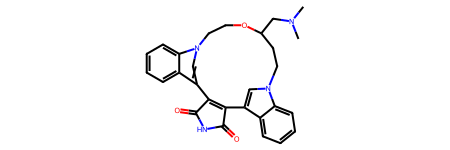

In [5]:
query = Chem.MolFromSmiles("CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C6=CC=CC=C65)C(=O)NC4=O") # SMILES of Ruboxistaurin
query

Generate Morgan fingerprints for the query molecule Ruboxistaurin.

In [6]:
circular_fp_query = rdFingerprintGenerator.GetFPs([query])[0]

# See the fingerprint as a bit
circular_fp_query.ToBitString()

'000000000100000000000000000000000000000000010100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000001000000000000000000000000000000000000000000000000000000100000000001000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000001010001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000001000000000000000000000000000000000000000000000000

Generate Morgan fingerprints for all molecules in our dataset.

In [7]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetFPs(molecule_dataset["ROMol"].tolist())

Calculate the Tanimoto similarity between the query molecule Ruboxistaurin and all molecules our dataset using Morgan fingerprints

In [8]:
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)
molecule_dataset.head(3)

,molecule_chembl_id,pIC50,smiles,ROMol,tanimoto_morgan
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0D...,0.305882
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0D...,0.106383
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x00000159E0D...,0.138298


In [9]:
molecule_dataset.sort_values(by = ["tanimoto_morgan"], ascending=False, inplace=True)
molecule_dataset.head(5)

,molecule_chembl_id,pIC50,smiles,ROMol,tanimoto_morgan
572,CHEMBL336179,7.58,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCn1...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0E...,0.603774
1079,CHEMBL131035,6.87,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCn1cc2c2c...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0E...,0.603774
1247,CHEMBL340259,6.66,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCn1cc2...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0E...,0.603774
786,CHEMBL130774,7.29,O=C1NC(=O)C2=C1c1cn(c3ccccc13)CCOCCOCCOCCOCCOC...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0E...,0.603774
175,CHEMBL321315,8.40,CN1CCCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)c2cn(c3cc...,<rdkit.Chem.rdchem.Mol object at 0x00000159E0E...,0.593220


So let's see the query and its most similar molecules

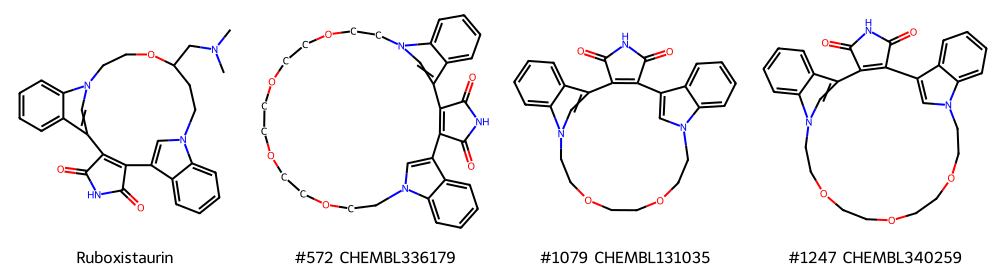

In [10]:
top_n_molecules = 3
top_molecules = molecule_dataset[:top_n_molecules]
legends = [
    f"#{index} {molecule['molecule_chembl_id']}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Ruboxistaurin"] + legends),
    molsPerRow=4,
    subImgSize=(250, 270),
)

**Now we can plot distribution of Tanimoto similarity**

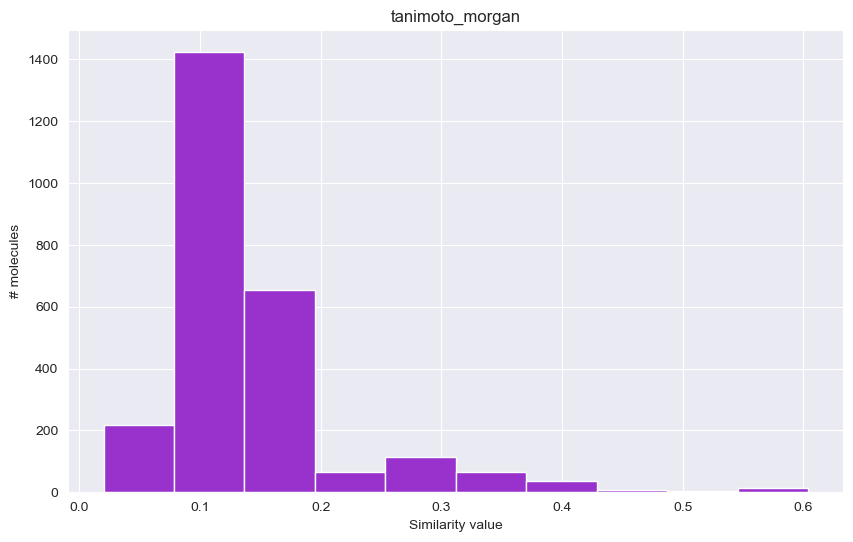

In [12]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=1) # Set up the matplotlib figure
molecule_dataset.hist(["tanimoto_morgan"], ax=axes, color = "darkorchid") # You can see more color name in the link https://www.w3schools.com/colors/colors_names.asp
axes.set_xlabel("Similarity value")
axes.set_ylabel("# molecules")
fig;

We can also do histogram with a kernel density estimates curve using seaborn. With this plot we can see easier how is it distributed the dataset

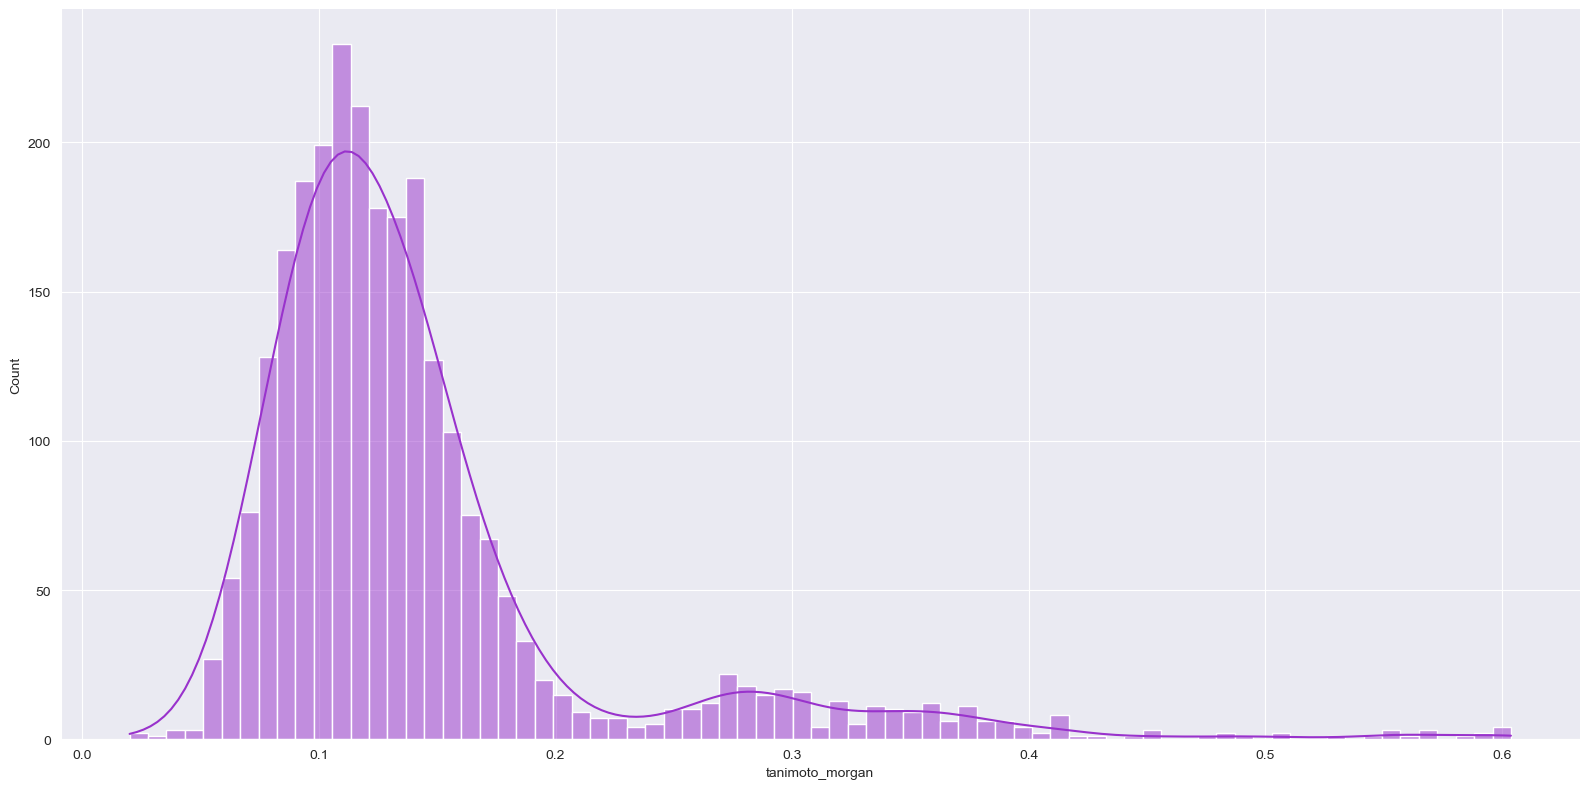

In [13]:
sns.displot(
    data=molecule_dataset["tanimoto_morgan"], 
    kde=True,
    height=8,
    aspect=2,
    color="darkorchid",
)

### Clustering
Now we are going to make clusters with the Tanomoto distance between the compounds (without a reference or query compound). For these we adapted the tutorial from [T005 · Compound clustering](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T005_compound_clustering/talktorial.ipynb)

**1. Data preparation and compound encoding**

In [14]:
compound_df = pd.read_csv(
    'data/compounds_P49841_full.csv',
    usecols=["molecule_chembl_id", "smiles", "pIC50"]
)
print(compound_df.shape)
compound_df.head()

(2605, 3)


,molecule_chembl_id,pIC50,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
2,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4077376,9.70,C[C@@H]1CN(c2ccccc2F)CCN1c1nc(-c2ccncn2)cc(=O)n1C


In [15]:
# Create molecules from SMILES and store in array
compounds = []

# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():   # .itertuples() returns a tuple per row
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x159e686ceb0>, 'CHEMBL2386094'),
 (<rdkit.Chem.rdchem.Mol at 0x159e687f6d0>, 'CHEMBL4084855'),
 (<rdkit.Chem.rdchem.Mol at 0x159e687f5f0>, 'CHEMBL3895998'),
 (<rdkit.Chem.rdchem.Mol at 0x159e687fa50>, 'CHEMBL564450'),
 (<rdkit.Chem.rdchem.Mol at 0x159e687fe40>, 'CHEMBL4077376')]

We will calculate the circular Morgan fingerprints with rdkit. The Morgan fingerprint can be calculated either as int or bit vector. By default the radius is 2 and the vector is 2048 long.

In [16]:
# Create fingerprints for all molecules as bit vector
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]
fingerprints[:5]

**2. Tanimoto similarity and distance matrix**

We will define functions to calculate the Tanimoto similarity and similarity matrix.

In [17]:
def tanimoto_matrix(fp_list):
    # Create a identity matrix whose diagonal is 0.5
    similarity_matrix = 0.5*np.identity(len(fp_list))
    for ind, i in enumerate(fp_list):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(i, fp_list[:ind])
        # Create a vector with the Tanimoto coefficient and zeros
        n_zeros = len(fp_list) - len(similarities)
        similarities.extend(np.zeros(n_zeros))
        # Take the vector with the Tanimoto coefficiente and zeros and arrange it in the matrix
        similarity_matrix[ind] = similarity_matrix[ind] + similarities
    # Addition the constructed matrix and its transpose (swap rows for columns)
    return similarity_matrix + similarity_matrix.T

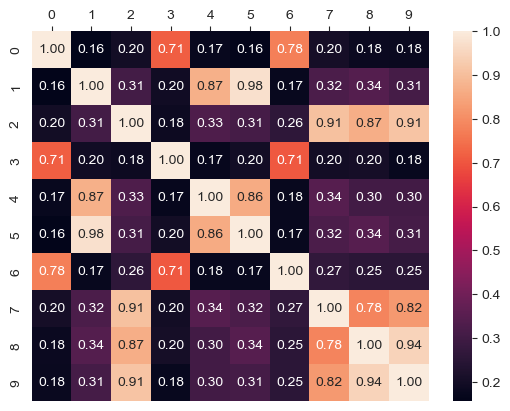

In [18]:
similarity_matrix = tanimoto_matrix(fingerprints[0:10]) # Only for the first 10 compounds
ax = sns.heatmap(similarity_matrix, annot=True, fmt='.2f') # annot= True print the Tanimoto coefficient and fmt='.2f' it gives me only two decimals 
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

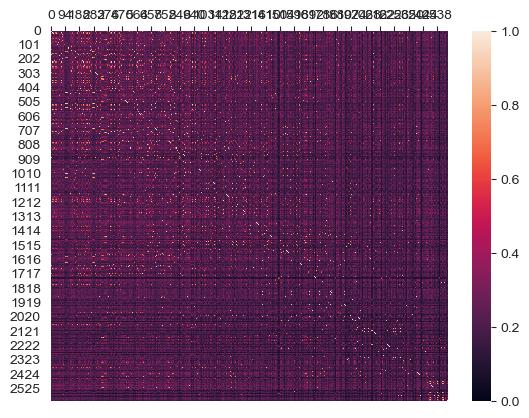

In [19]:
similarity_matrix = tanimoto_matrix(fingerprints)
ax = sns.heatmap(similarity_matrix)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

**3. Clustering** 

Now we will define a clustering fuction

In [20]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [21]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.2)

We can have a short report about the numbers of clusters and their sizes

In [22]:
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  790
# clusters with only 1 compound:  488
# clusters with >5 compounds:  100
# clusters with >25 compounds:  14
# clusters with >100 compounds:  0


Also we can plot the size of the clusters

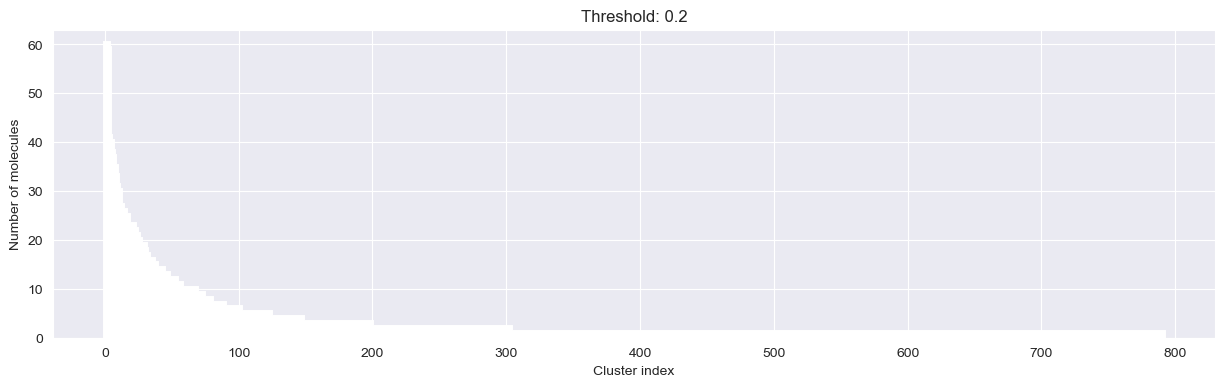

In [23]:
fig, ax = plt.subplots(figsize=(15, 4)) # Set up the matplotlib figure
ax.set_title(f"Threshold: 0.2")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, color="mediumseagreen");

As we see in the theory the clustering result depends on the threshold chosen, so lets visualize diferrents cutoff

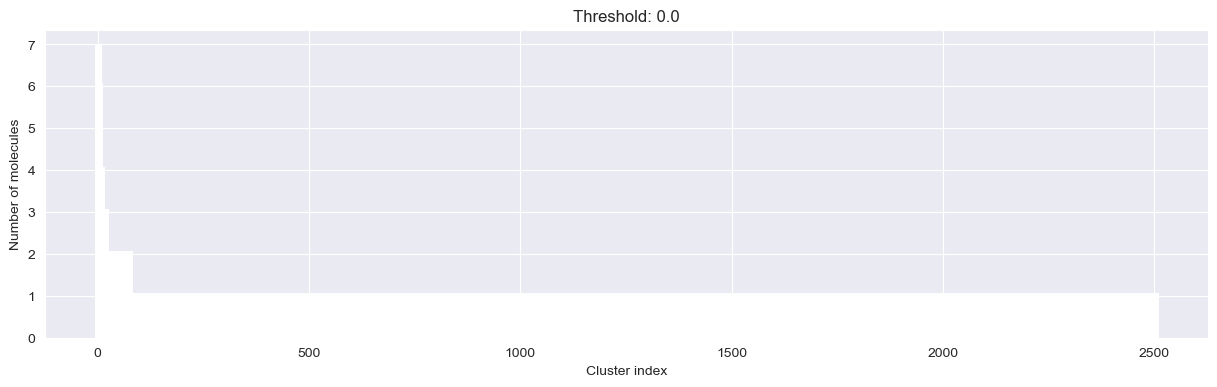

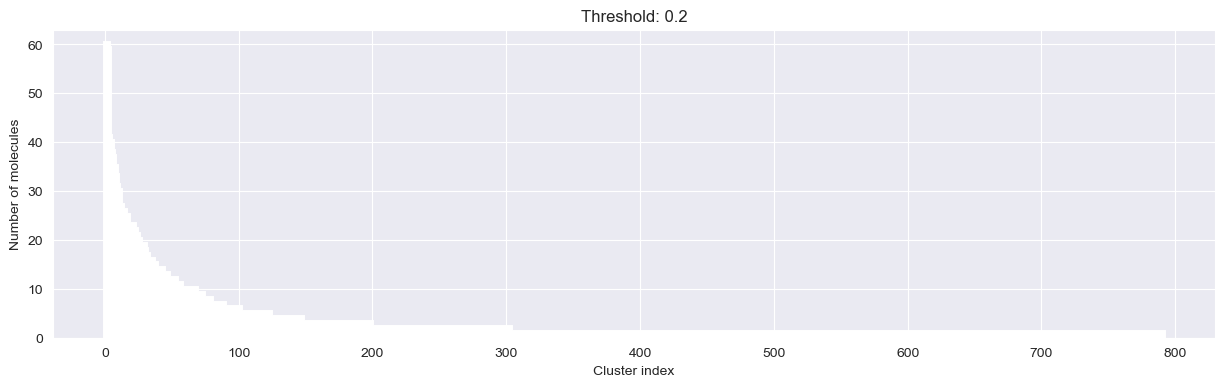

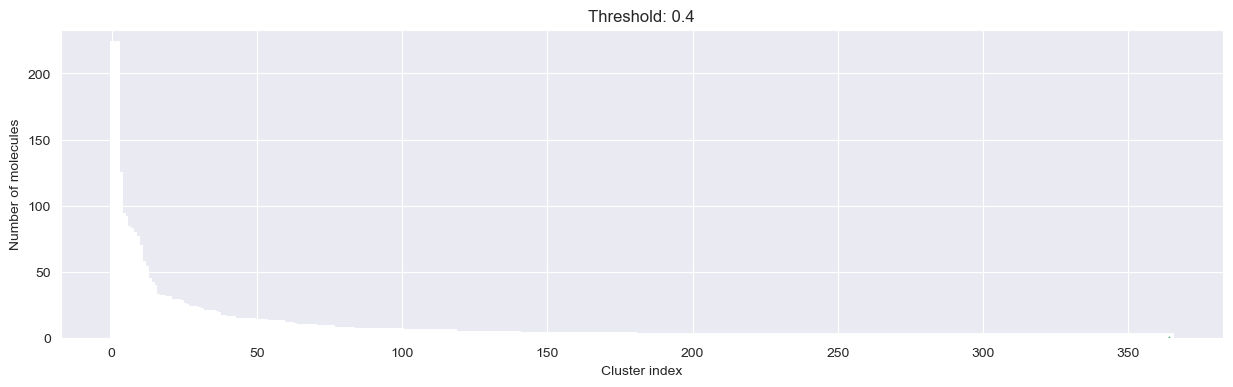

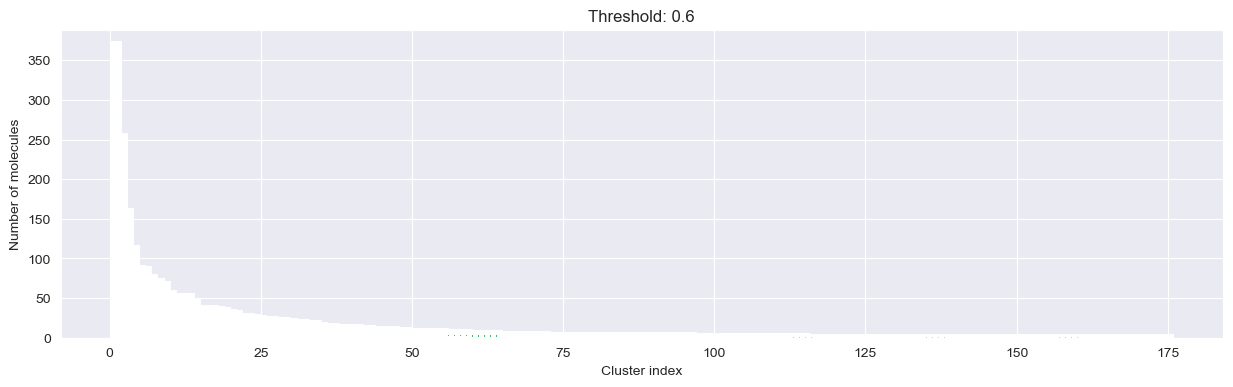

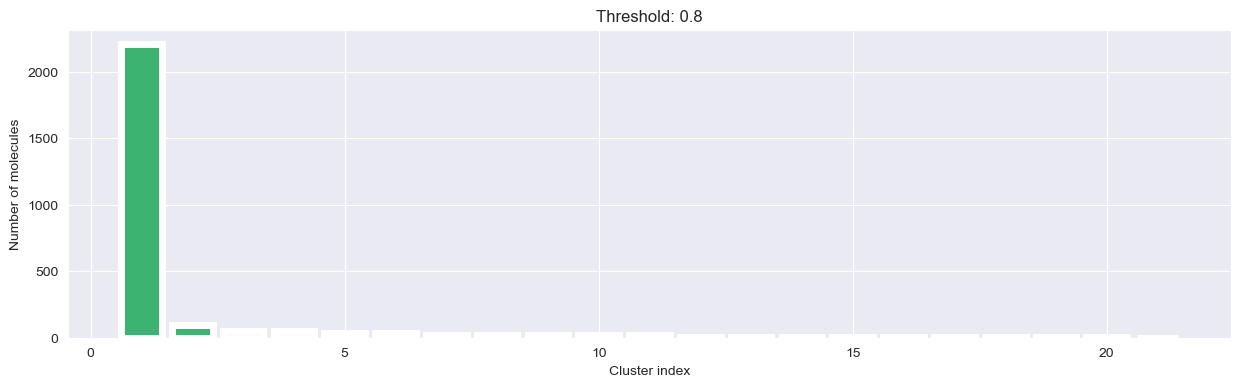

In [24]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))  # Set up the matplotlib figure
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5, color="mediumseagreen")
    plt.show()
    plt.close()

With the plots above, we can see that the best two distance threshold are 0.2 and 0.4, they have not many singletons and the cluster sizes don't have an extreme but smooth distribution. But lets have a short report about the numbers of clusters and their sizes in order to decided the cut-off distance.

Number of clusters: 790 from 2605 molecules at distance cut-off 0.2
Number of molecules in largest cluster: 60
# clusters with only 1 compound:  488
# clusters with >5 compounds:  100
# clusters with >25 compounds:  14
# clusters with >100 compounds:  0


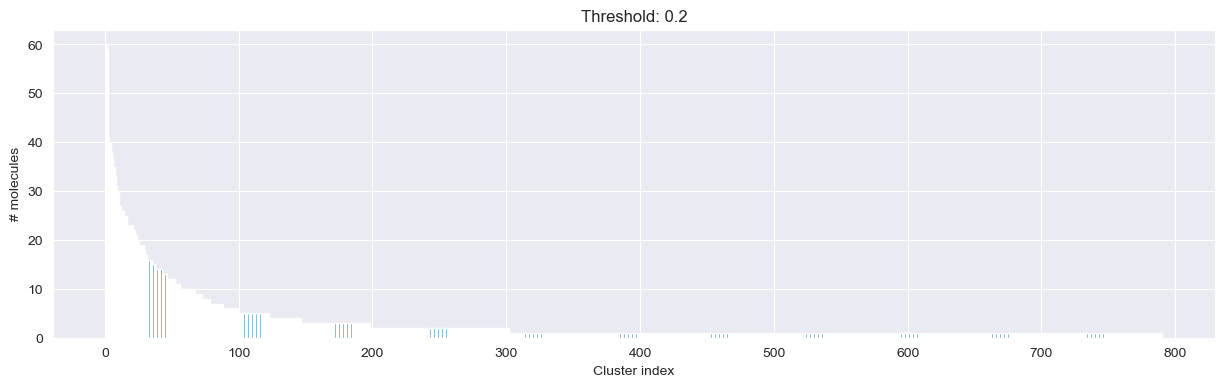

In [25]:
cutoff = 0.2
cluster_02 = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4)) # Set up the matplotlib figure
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(cluster_02) + 1), [len(c) for c in cluster_02])
ax.set_title(f"Threshold: {cutoff:3.1f}")

print(f"Number of clusters: {len(cluster_02)} from {len(compounds)} molecules at distance cut-off 0.2")
print("Number of molecules in largest cluster:", len(cluster_02[0]))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

Number of clusters: 364 from 2605 molecules at distance cut-off 0.4
Number of molecules in largest cluster: 222
# clusters with only 1 compound:  488
# clusters with >5 compounds:  100
# clusters with >25 compounds:  14
# clusters with >100 compounds:  0


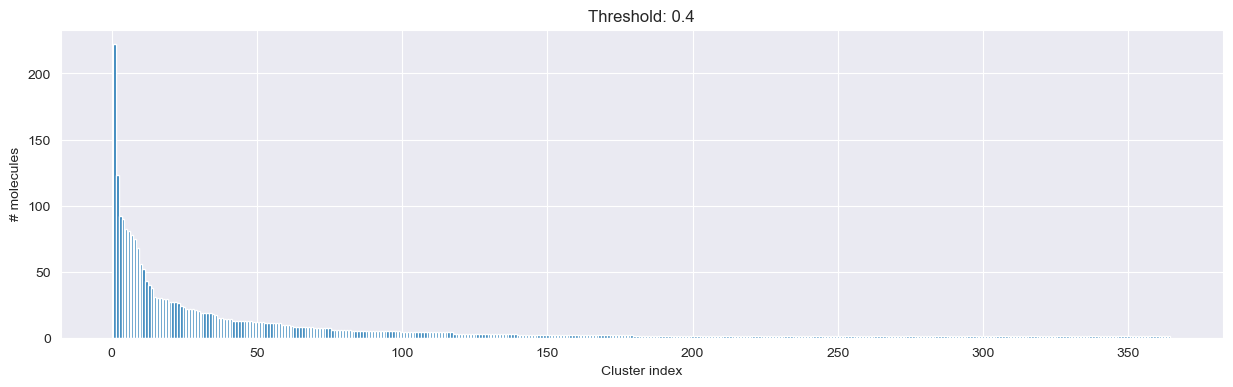

In [26]:
cutoff = 0.4
cluster_04 = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4)) # Set up the matplotlib figure
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(cluster_04) + 1), [len(c) for c in cluster_04])
ax.set_title(f"Threshold: {cutoff:3.1f}")

print(f"Number of clusters: {len(cluster_04)} from {len(compounds)} molecules at distance cut-off 0.4")
print("Number of molecules in largest cluster:", len(cluster_04[0]))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

We can see that the main difference between the cut-off distance of 0.2 and 0.4 is the total number of clusters. So in this case we will choose a distance threshold of 0.2 because let´s remember that the smaller the distance value cut-off, the more similar the compounds are required to be to belong to one cluster.

**Now, let's have a closer look at the first 5 molecular structures of the first/largest clusters.**

Five molecules from largest cluster:


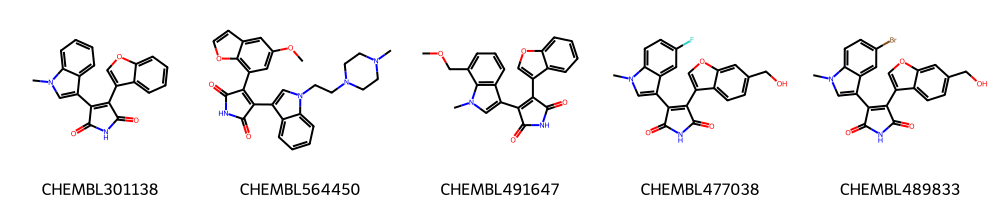

In [27]:
print("Five molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in cluster_02[0][:5]],
    legends=[compounds[i][1] for i in cluster_02[0][:5]],
    molsPerRow=5,
)

For comparison, we can have a look at the cluster centers of the first 10 clusters.

Ten molecules from first 10 clusters:


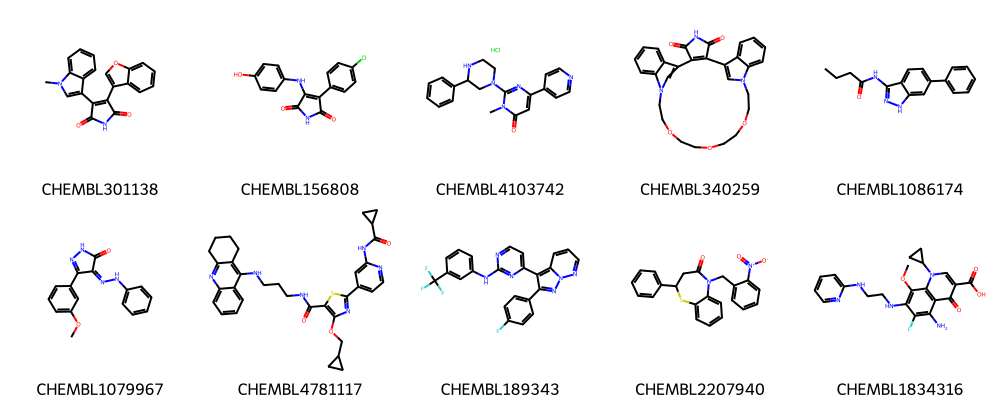

In [28]:
print("Ten molecules from first 10 clusters:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[cluster_02[i][0]][0] for i in range(10)],
    legends=[compounds[cluster_02[i][0]][1] for i in range(10)],
    molsPerRow=5,
)

## Practical activity

Taking into account what you have learned in this Notebook, answer:
1. Visualize diferrents cutoff with an interval of 0.1 between each
2. Select a different and appropriate threshold and visualize the clusters centers of the first 10 clusters.

## Conclusion

In this practice, we have learned about how to use fingerprints and similarity measures to compare a query molecule with a dataset of molecules and rank the molecule by similarity. Also, we have lerned about clustering a compound dataset and discussed how to pick a reasonable clustering threshold.